# Model Training & Validation

This is the **2nd** of the 3 example notebooks:

> 1. `preprocessing.ipynb`
> 2. ### **`training.ipynb`**
> 3. `inference.ipynb`

### Contents

- **Load Training Data**: this is the output of `preprocessing.ipynb`
- **Setup Model**: define cnn architecture, loss function, batching, metrics
- **Train Model**: self-explanatory
- **Validation**: check metrics, and plot validation images
- **Save Model**: to be used in `inference.ipynb`

In [1]:
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import string
from tqdm.notebook import tqdm

from scipy.ndimage import shift
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from keras import backend as K

##### Constants

In [2]:
N = 70
DX = 1.0e-6
cloud_radius = 22.5e-6

n_mus = 8
n_fields = 2500
m = n_mus * n_fields

# filter size for NMS
f = 3

## 1. Load the training data

In [3]:
data_path = "../qvortex-detection/single_layer/essential/data"
training_data_path = f"{data_path}/training/70x70 temp 50 mu 1000-1350 fields 2500 18.9.24"

X = np.memmap(f"{training_data_path}/X.npy", dtype='float64', mode='r', shape=(m, N, N))
Y = np.memmap(f"{training_data_path}/Y.npy", dtype='float64', mode='r', shape=(m, N, N, 1))
phase = np.memmap(f"{training_data_path}/phase.npy", dtype='float64', mode='r', shape=(m, N, N))

print(f"X: {X.shape}", f"Y: {Y.shape}", f"phase: {phase.shape}",sep="\n")

X: (20000, 70, 70)
Y: (20000, 70, 70, 1)
phase: (20000, 70, 70)


### 1.1 Compare training and experimental images

In [4]:
X_exp = np.load(f"{data_path}/test/70x70 images_clipped.npy")

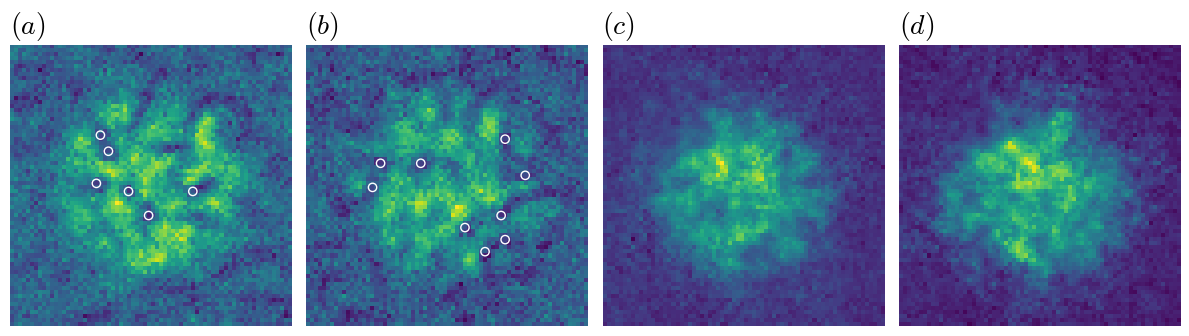

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))
indices = [1000, 1001, 0, 4]
for i, ax in enumerate(axes.flat):
    if i < 2:
        ax.imshow(X[indices[i]])
        vortices = Y[indices[i], :, :, 0]
        points = np.where(vortices!=0)
        ax.scatter(points[1], points[0], marker='o', facecolors='none', edgecolors='white', alpha=1.0)
    else:
        ax.imshow(X_exp[indices[i]])

    ax.text(0.0, 1.04, f"$({string.ascii_lowercase[i]})$", transform=ax.transAxes, size=20, weight='normal')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## 2. Split Into Train and Validation Sets

### 2.1 Split on ids for memory efficiency and stratify by chemical potential

In [6]:
strata = np.zeros(len(X))
for i in range(n_mus):
    strata[n_fields*i:n_fields*(i+1)] = i

In [7]:
X_ids = list(range(len(X)))
Y_ids = list(range(len(Y)))
X_train_ids, X_val_ids, Y_train_ids, Y_val_ids = train_test_split(X_ids, Y_ids, test_size=0.05, stratify=strata, random_state=0, shuffle=True)

### 2.2 Define generators for memory efficiency

In [8]:
class My_Custom_Generator(keras.utils.Sequence) :
    """Generator class that loads batches of X and Y from the disk to be used in training"""
    def __init__(self, X_ids, Y_ids, batch_size) :
        self.X_ids = X_ids
        self.Y_ids = Y_ids
        self.batch_size = batch_size
    
    def __len__(self) :
        return (np.ceil(len(self.X_ids) / float(self.batch_size))).astype(np.int64)
  
    def __getitem__(self, idx):
        batch_X = X[self.X_ids[idx * self.batch_size : (idx+1) * self.batch_size]]
        batch_Y = Y[self.Y_ids[idx * self.batch_size : (idx+1) * self.batch_size]]
    
        return batch_X, batch_Y

In [9]:
batch_size = 32

my_training_batch_generator = My_Custom_Generator(X_train_ids, Y_train_ids, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_ids, Y_val_ids, batch_size)

## 3. Training

### 3.1 Define the Loss Function

In [10]:
class custom_loss_function(tf.keras.losses.Loss):
    def __init__(self, w1, epsilon=1e-5, name='custom_loss_function'):
        super().__init__(name=name)
        self.w1 = w1
        self.epsilon = epsilon

    def call(self, Y, Y_pred):
        Y_pred = tf.clip_by_value(Y_pred, self.epsilon, 1 - self.epsilon)
        
        log_cost = -(self.w1 * Y * tf.math.log(Y_pred) + (1 - Y) * tf.math.log(1 - Y_pred))
        log_loss = tf.math.reduce_mean(log_cost)

        return log_loss

### 3.2 Define Metrics
#### Standard Precision, Recall & F1

In [11]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [13]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Allowing for off-by-one errors

In [14]:
def precision_ob1(y_true, y_pred):
    y_pred_up = shift(y_pred, (0, -1, 0))
    y_pred_right = shift(y_pred, (0, 0, -1))
    y_pred_down = shift(y_pred, (0, 1, 0))
    y_pred_left = shift(y_pred, (0, 0, 1))

    pred_sum = y_pred + y_pred_up + y_pred_right + y_pred_down + y_pred_left
    true_positives = K.sum(K.round(K.clip(pred_sum * y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [15]:
def recall_ob1(y_true, y_pred):
    y_pred_up = shift(y_pred, (0, -1, 0))
    y_pred_right = shift(y_pred, (0, 0, -1))
    y_pred_down = shift(y_pred, (0, 1, 0))
    y_pred_left = shift(y_pred, (0, 0, 1))

    pred_sum = y_pred + y_pred_up + y_pred_right + y_pred_down + y_pred_left
    true_positives = K.sum(K.round(K.clip(pred_sum * y_true, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [16]:
def f1_ob1(y_true, y_pred):
    precision = precision_ob1(y_true, y_pred)
    recall = recall_ob1(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### 3.3 Define the Convolutional Architecture & Compile

In [17]:
def make_model(alpha, w1):
    """Generates a fresh CNN"""
    keras.backend.clear_session()
    model = tf.keras.Sequential(layers=[
        ### block 1
        tfl.Conv2D(30, 5, strides=(1,1), padding='same', activation='relu', input_shape=(N, N, 1)),
        tfl.BatchNormalization(),
        tfl.Conv2D(25, 5, strides=(1,1), padding='same', activation='relu'),
        tfl.BatchNormalization(),
        # tfl.MaxPooling2D((2,2), strides=1, padding='same'),
        tfl.Conv2D(20, 3, strides=(1,1), padding='same', activation='relu'),
        tfl.BatchNormalization(),
        tfl.Conv2D(1, 3, strides=(1,1), padding='same', activation='sigmoid'),
    ])

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_m
    ]


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
                  loss=custom_loss_function(w1=w1),
                  metrics=METRICS)
    
    print(model.summary(line_length=100))

    return model

In [18]:
def train_model(model, train_gen, valid_gen, epochs, batch_size):
    """Train the CNN"""
    history = model.fit(x = train_gen,
                        steps_per_epoch = int(len(X_train_ids) // batch_size),
                        epochs = epochs,
                        verbose = 1,
                        validation_data = valid_gen,
                        validation_steps = int(len(X_val_ids) // batch_size))
    
    return history

In [19]:
def visualise_training(history):
    """Visualises the metrics over the course of model training."""
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(6, 6))

    plot_metrics = [['Loss Function', 'loss', 'val_loss'],
                    ['Precision', 'precision', 'val_precision'],
                    ['Recall', 'recall', 'val_recall'],
                    ['F1', 'f1_m', 'val_f1_m']]

    for i, ax in enumerate(axes.flat):
        title, plot, val_plot = plot_metrics[i]
        
        ax.set_title(title)
        ax.plot(history.history[plot], label='train')
        ax.plot(history.history[val_plot], label='validation')
        ax.set_xticks(range(-1, 10, 2), labels=range(0, 11, 2))
        ax.set_xlim([-1, 10])

    axes[0, 1].legend()
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 1].set_xlabel("Epoch")
    axes[0, 0].set_yscale("log")

    
    plt.tight_layout()
    plt.show()

### 3.4 Train the model

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
label = '70_noise_v106'

alpha = 0.0001
w1 = 3.3 # larger w1 = more positive guesses = higher recall, lower precision
epochs = 10

model = make_model(alpha=alpha, w1=w1)
history = train_model(model, my_training_batch_generator, my_validation_batch_generator, epochs, batch_size)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 70, 70, 30)                      780            
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 70, 70, 30)                      120            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 70, 70, 25)                      18775          
                                                                                                    
 batch_normalization_1 (BatchNormalization)  (None, 70, 70, 25)                      100            
                                                                       

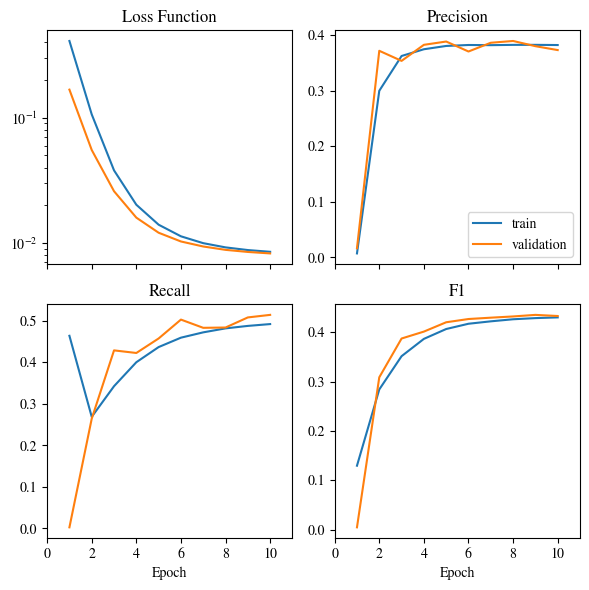

In [22]:
visualise_training(history)

## 4. Validation
### 4.1 Raw validation scores

In [23]:
loss, accuracy, precision, recall, f1 = model.evaluate(my_validation_batch_generator)

32/32 [==============================] - 0s 12ms/step - loss: 0.0082 - accuracy: 0.9981 - precision: 0.3733 - recall: 0.5151 - f1_m: 0.4358


### 4.2 Apply NMS supression to clean up predictions

In [24]:
predictions = model.predict(my_validation_batch_generator)[:, :, :, 0]

32/32 [==============================] - 0s 3ms/step


In [25]:
def nms(pred):
    """Perform Non-Max Supression (NMS) on predictions"""
    pred_nms = pred.copy()
    for j in range(N - f):
        for i in range(N - f):
            filter = pred_nms[j:j+f, i:i+f]
            if (filter >= 0.5).sum() > 1:
                max_idx = np.unravel_index(np.argmax(filter), shape=filter.shape)
                if max_idx == (1, 1):
                    replacement = np.zeros((f, f))
                    replacement[max_idx] = filter[max_idx]
                    pred_nms[j:j+f, i:i+f] = replacement

    return pred_nms

In [26]:
predictions_nms = np.zeros_like(predictions)
for i in tqdm(range(predictions.shape[0])):
    predictions_nms[i] = nms(predictions[i])

predictions_nms_rounded = np.where(predictions_nms >= 0.5, 1, 0)

  0%|          | 0/1000 [00:00<?, ?it/s]

### 4.3 Off-by-one Validation Scores

In [27]:
prec_ob1 = tf.get_static_value(precision_ob1(Y[Y_val_ids][:, :, :, 0], predictions_nms_rounded.astype(np.float64)))
rec_ob1 = tf.get_static_value(recall_ob1(Y[Y_val_ids][:, :, :, 0], predictions_nms_rounded.astype(np.float64)))
f1_score_ob1 = tf.get_static_value(f1_ob1(Y[Y_val_ids][:, :, :, 0], predictions_nms_rounded.astype(np.float64)))

In [28]:
print(f"precision: {prec_ob1:.4f}\nrecall: {rec_ob1:.4f}\nf1: {f1_score_ob1:.4f}")

precision: 0.7524
recall: 0.6873
f1: 0.7184


### 4.4 Visualise Validation Examples

In [29]:
def mask(mask_radius=cloud_radius):
    pixel_radius = int(mask_radius / DX)
    x_arange = (np.arange(N) - N / 2)
    y_arange = (np.arange(N) - N / 2)
    X_grid, Y_grid = np.meshgrid(x_arange, y_arange)
    R = np.sqrt(X_grid ** 2 + Y_grid ** 2)
    mask = (R <= pixel_radius)
    return mask

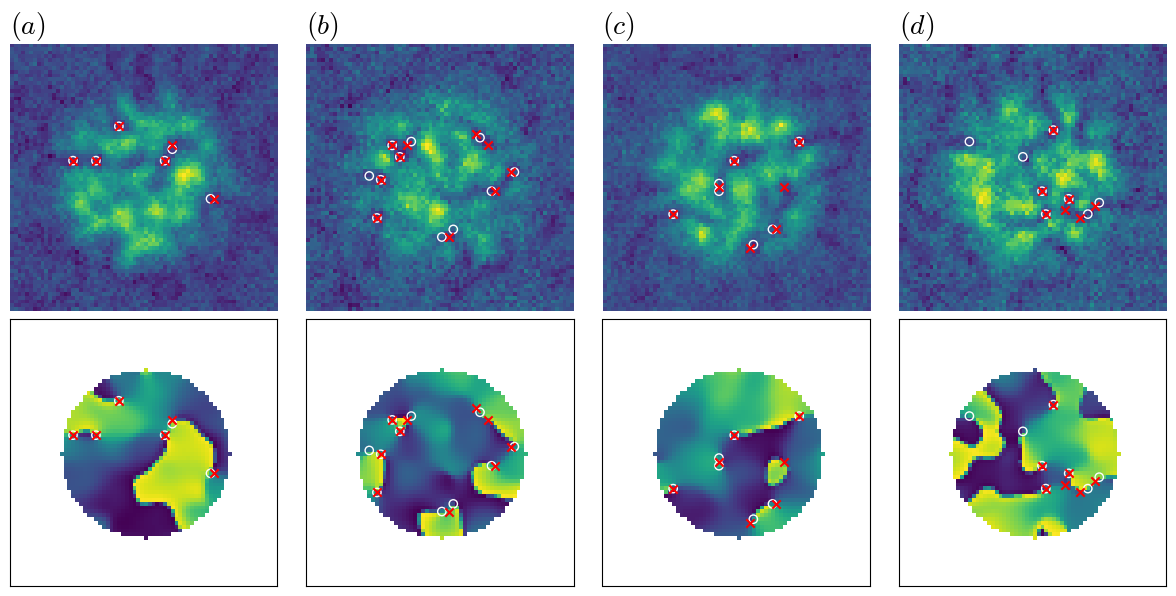

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

ref = 1
indices = [4*ref, 4*ref + 1, 4*ref + 2, 4*ref + 3]

phase_mask = mask(cloud_radius)*1.0
phase_mask[phase_mask==0.0] = np.nan

for i, ax in enumerate(axes.flat):
    idx = X_val_ids[indices[i % 4]]
    if i < 4:
        ax.imshow(X[idx])
        ax.text(0.0, 1.04, f"$({string.ascii_lowercase[i]})$", transform=ax.transAxes, size=20, weight='normal')
        ax.set_axis_off()
    else:
        ax.imshow(phase_mask*phase[idx])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    Y_index = Y[idx, :, :, 0]
    Y_pred = predictions_nms_rounded[indices[i % 4]]
    points = np.where(Y_index!=0)
    points_pred = np.where(Y_pred!=0)
    ax.scatter(points[1], points[0], marker='o', facecolors='none', edgecolors='white')
    ax.scatter(points_pred[1], points_pred[0], marker='x', color='red')

plt.tight_layout()
plt.show()

## 5. Save Model

In [31]:
label

'70_noise_v106'

In [32]:
model.save(f'./models/{label}.keras')

In [33]:
perform_df = pd.DataFrame({
    'version': [label],
    'dataset': [training_data_path],
    'w1': [w1],
    'val_loss': [loss],
    'val_accuracy': [accuracy],
    'val_precision': [precision],
    'val_recall': [recall],
    'val_f1': [f1],
    'val_prec_ob1': [prec_ob1],
    'val_rec_ob1': [rec_ob1],
    'val_f1_ob1': [f1_score_ob1],
})

perform_df.head()

,version,dataset,w1,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_prec_ob1,val_rec_ob1,val_f1_ob1
0,70_noise_v106,../qvortex-detection/single_layer/essential/da...,3.3,0.00823,0.998098,0.373308,0.51513,0.435825,0.752417,0.687274,0.718372
